# Solve fluid diffusion equation in a rectangular domain with imposed flux on L_left

In [1]:
import numpy as np
from mpi4py import MPI
import pyvista
import ufl

from ufl import Measure

from dolfinx import fem, plot
from dolfinx.io import XDMFFile
from dolfinx.fem import FunctionSpace, Constant, Function

from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

## Read the mesh

In [2]:
# Read the mesh
with XDMFFile(MPI.COMM_WORLD, "mesh_rectangle/linear/rectangle_mesh.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    cell_tags = xdmf.read_meshtags(mesh, name="Grid")
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)

with XDMFFile(MPI.COMM_WORLD, "mesh_rectangle/linear/rectangle_facet_mesh.xdmf", "r") as xdmf:
    facet_tags = xdmf.read_meshtags(mesh, name="Grid")

## Plot the mesh

In [3]:
topology, cell_types, geometry = plot.create_vtk_mesh(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

pyvista.set_jupyter_backend("pythreejs")

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

## Define temporal parameters

In [4]:
t = 0 # Start time
T = 1000.0 # Final time 1000
num_steps = 100     
dt = T / num_steps # time step size

## Finite element function space

In [5]:
V = FunctionSpace(mesh, ("CG", 1))  # Lagrange element and and linear elements (degree 1)

## Set initial conditions

In [6]:
p_n = Function(V)
p_n.name = "p_n"

## Boundary conditions

In [7]:
# DIRICHLET: p=0 on all Dirichlet BC (side 4)
boundary_dofs = fem.locate_dofs_topological(V, mesh.topology.dim-1, facet_tags.indices[facet_tags.values == 4])
bc = fem.dirichletbc(ScalarType(0), boundary_dofs, V)

# NEUMANN: dp/dn=-4 on the left side (side 3)
# here we only want to integrate on the left side so we can create a custom integration measure ds which only integrates over facets marked with value i
ds = Measure("ds", domain=mesh, subdomain_data=facet_tags)
g = -4

## Time-dependent output

In [8]:
p_h = p_n.copy()
p_h.name = "p_h"

## Trial and test functions

In [9]:
p, r = ufl.TrialFunction(V), ufl.TestFunction(V)

## Source term

In [10]:
# here f=0 as there is no source term
f = fem.Constant(mesh, ScalarType(0))

## Variational problem

As the test function is zero on the boundary integrals over the Dirichlet boundary, we can integrate g*v*ds over the entire boundary.

In [11]:
S = 1
kappa = 1

In [12]:
a = S * p * r * ufl.dx + dt * kappa * ufl.dot(ufl.grad(p), ufl.grad(r)) * ufl.dx 
L = (S * p_n + dt * f) * r * ufl.dx - dt * g * r * ds(3)

## Preparation of linear algebra structures for time dependent problems

In [13]:
bilinear_form = fem.form(a)
linear_form = fem.form(L)

In [14]:
# bilinear_form (a) isn't time dependant so we can assemble it once (we could do the same for the integral of the Neumann term as the flux is contant, but for now let's stay like that)
A = fem.petsc.assemble_matrix(bilinear_form, bcs=[bc])
A.assemble()
b = fem.petsc.create_vector(linear_form)

## Linear solver

In [15]:
# here matrix A is already assembled so we don't need to use petsc.LinearProblem like in tuto1
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

In [16]:
import pyvista
pyvista.set_jupyter_backend("ipygany")

grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(V))

def plot_function(t, uh):
    """
    Create a figure of the concentration uh warped visualized in 3D at timet step t.
    """
    p = pyvista.Plotter()
    # Update point values on pyvista grid
    grid.point_data[f"u({t})"] = uh.x.array.real
    # Warp mesh by point values
    warped = grid.warp_by_scalar(f"u({t})", factor=1.5)

    # Add mesh to plotter and visualize in notebook or save as figure
    actor = p.add_mesh(warped)
    if not pyvista.OFF_SCREEN:
        p.show()
    else:
        pyvista.start_xvfb()
        figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
        # Clear plotter for next plot
        p.remove_actor(actor)
plot_function(0, p_h)

AppLayout(children=(VBox(children=(HTML(value='<h3>u(0)</h3>'), Dropdown(description='Colormap:', options={'Br…

In [17]:
p_bottom_vec = [] # for saving
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)
    
    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, p_h.vector)
    p_h.x.scatter_forward()

    # Update solution at previous time step (u_n)
    p_n.x.array[:] = p_h.x.array

    # Plot every 15th time step
    if i % 15 == 0:
        plot_function(t, p_h)
    
    if t == 10 or t == 50 or t == 100 or t == 1000:
        # also save the values
        p_bottom_vec.append(p_h.x.array[mesh.geometry.x[:,1]==0])

AppLayout(children=(VBox(children=(HTML(value='<h3>u(10.0)</h3>'), Dropdown(description='Colormap:', options={…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(160.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(310.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(460.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(610.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(760.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(910.0)</h3>'), Dropdown(description='Colormap:', options=…

## Post-processing

We can compare the obtained steady state solution with the one computed by hand

In [18]:
import matplotlib.pyplot as plt

In [19]:
# analytical solution for a 1D diffusion in steady state
def p_analytical(x):
    source = -g  # same flow as Neumann
    L = 10
    return source/kappa*(L-x)

In [20]:
# look for the pressures on L_bottom
x_bottom = mesh.geometry.x[mesh.geometry.x[:,1]==0][:,0]
#p_bottom = p_h.x.array[mesh.geometry.x[:,1]==0]
# sort these pressures according to the radial distance from point A 
index_order = np.argsort(x_bottom)
x_numerical = x_bottom[index_order]
for ind, p_bottom in enumerate(p_bottom_vec):
    p_bottom_vec[ind] = p_bottom[index_order]
len(p_bottom_vec)

4

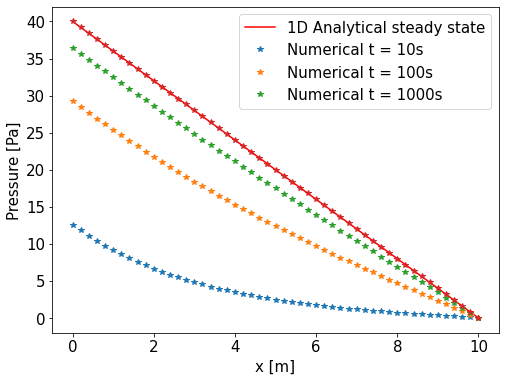

In [21]:
# plot with matplotlib

# x axis for analytical solution
x = np.arange(0., 10., 0.01)

# plot
plt.figure(figsize=(8, 6))
plt.plot(x, p_analytical(x), 'r-')
for ind, p_bottom in enumerate(p_bottom_vec):
    plt.plot(x_numerical, p_bottom, '*')
plt.legend(['1D Analytical steady state', 'Numerical t = 10s', 'Numerical t = 100s', 'Numerical t = 1000s'], loc='upper right', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('x [m]', fontsize=15)
plt.ylabel('Pressure [Pa]', fontsize=15) 
plt.savefig("edge_injection.png", )
plt.show()